In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

### Steps performed in the analysis
1. Reading, understanding and visualizing the data
2. Preparing the data for modelling (train-test split, rescaling etc.)
3. Training the model
4. Residual Analysis
5. Predictions and Evaluations on the test data set

## Step 1: Reading, Understanding and Visualizing the data

In [2]:
# Reading the data
bike = pd.read_csv('day.csv')

In [3]:
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bike.shape

(730, 16)

In [5]:
# Checking for null values
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### As there are no missing values, the rows and columns don't need any fixing

In [6]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [7]:
num_cols = ['cnt','temp','atemp','hum','windspeed']
cat_cols = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
others = ['instant','dteday']

### cnt = casual + registered
therefore casual and registered are not adding new information and hence, can be dropped

### droping the dteday and instant columns as the day and month are already captured in separate columns, date will not be of much help.

In [8]:
bike.drop('casual',axis=1, inplace=True)
bike.drop('registered',axis=1, inplace=True)
bike.drop('dteday',axis=1, inplace=True)
bike.drop('instant',axis=1, inplace=True)

In [9]:
bike.shape

(730, 12)

## Performing EDA

### Univariate Analysis

- As the data is in numbers, it will be difficult to visualise the data and make any sense out of it. Therefore, for the inital analysis, converting the numbers to the descrition using the data dictionary

### Visualizing the Categorical Variable

In [10]:
bike['yr'] = bike['yr'].apply(lambda x:'2018' if x==0 else '2019')

In [11]:
def month(argument):
    match argument:
        case 1:
            return "Jan"
        case 2:
            return "Feb"
        case 3:
            return "Mar"
        case 4:
            return "Apr"
        case 5:
            return "May"
        case 6:
            return "Jun"
        case 7:
            return "Jul"
        case 8:
            return "Aug"
        case 9:
            return "Sep"
        case 10:
            return "Oct"
        case 11:
            return "Nov"
        case 12:
            return "Dec"
        
bike['mnth'] = bike['mnth'].apply(month)

In [12]:
def season(argument):
    match argument:
        case 1:
            return "Spring"
        case 2:
            return "Summer"
        case 3:
            return "Fall"
        case 4:
            return "Winter"
        
bike['season'] = bike['season'].apply(season)

In [13]:
def weekday(argument):
    match argument:
        case 0:
            return "Tue"
        case 1:
            return "Wed"
        case 2:
            return "Thu"
        case 3:
            return "Fri"
        case 4:
            return "Sat"
        case 5:
            return "Sun"
        case 6:
            return "Mon"
        

bike['weekday'] = bike['weekday'].apply(weekday)

In [14]:
def weathersituation(argument):
    match argument:
        case 1:
            return "Clear"
        case 2:
            return "Mist"
        case 3:
            return "Light Snow"
        case 4:
            return "Heavy Rain"
        
bike['weathersit'] = bike['weathersit'].apply(weathersituation)

In [15]:
def holiday(argument):
    match argument:
        case 0:
            return "No"
        case 1:
            return "Yes"
        
bike['holiday'] = bike['holiday'].apply(holiday)

In [16]:
def workingday(argument):
    match argument:
        case 0:
            return "No"
        case 1:
            return "Yes"
        
bike['workingday'] = bike['workingday'].apply(workingday)

#### The above conversions are done for easy visualization of the data in Univariate Analysis. Later the same will be used to create dummy variables.

In [17]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,No,Mon,No,Mist,14.110847,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,No,Tue,No,Mist,14.902598,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,No,Wed,Yes,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,No,Thu,Yes,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,No,Fri,Yes,Clear,9.305237,11.46350,43.6957,12.522300,1600


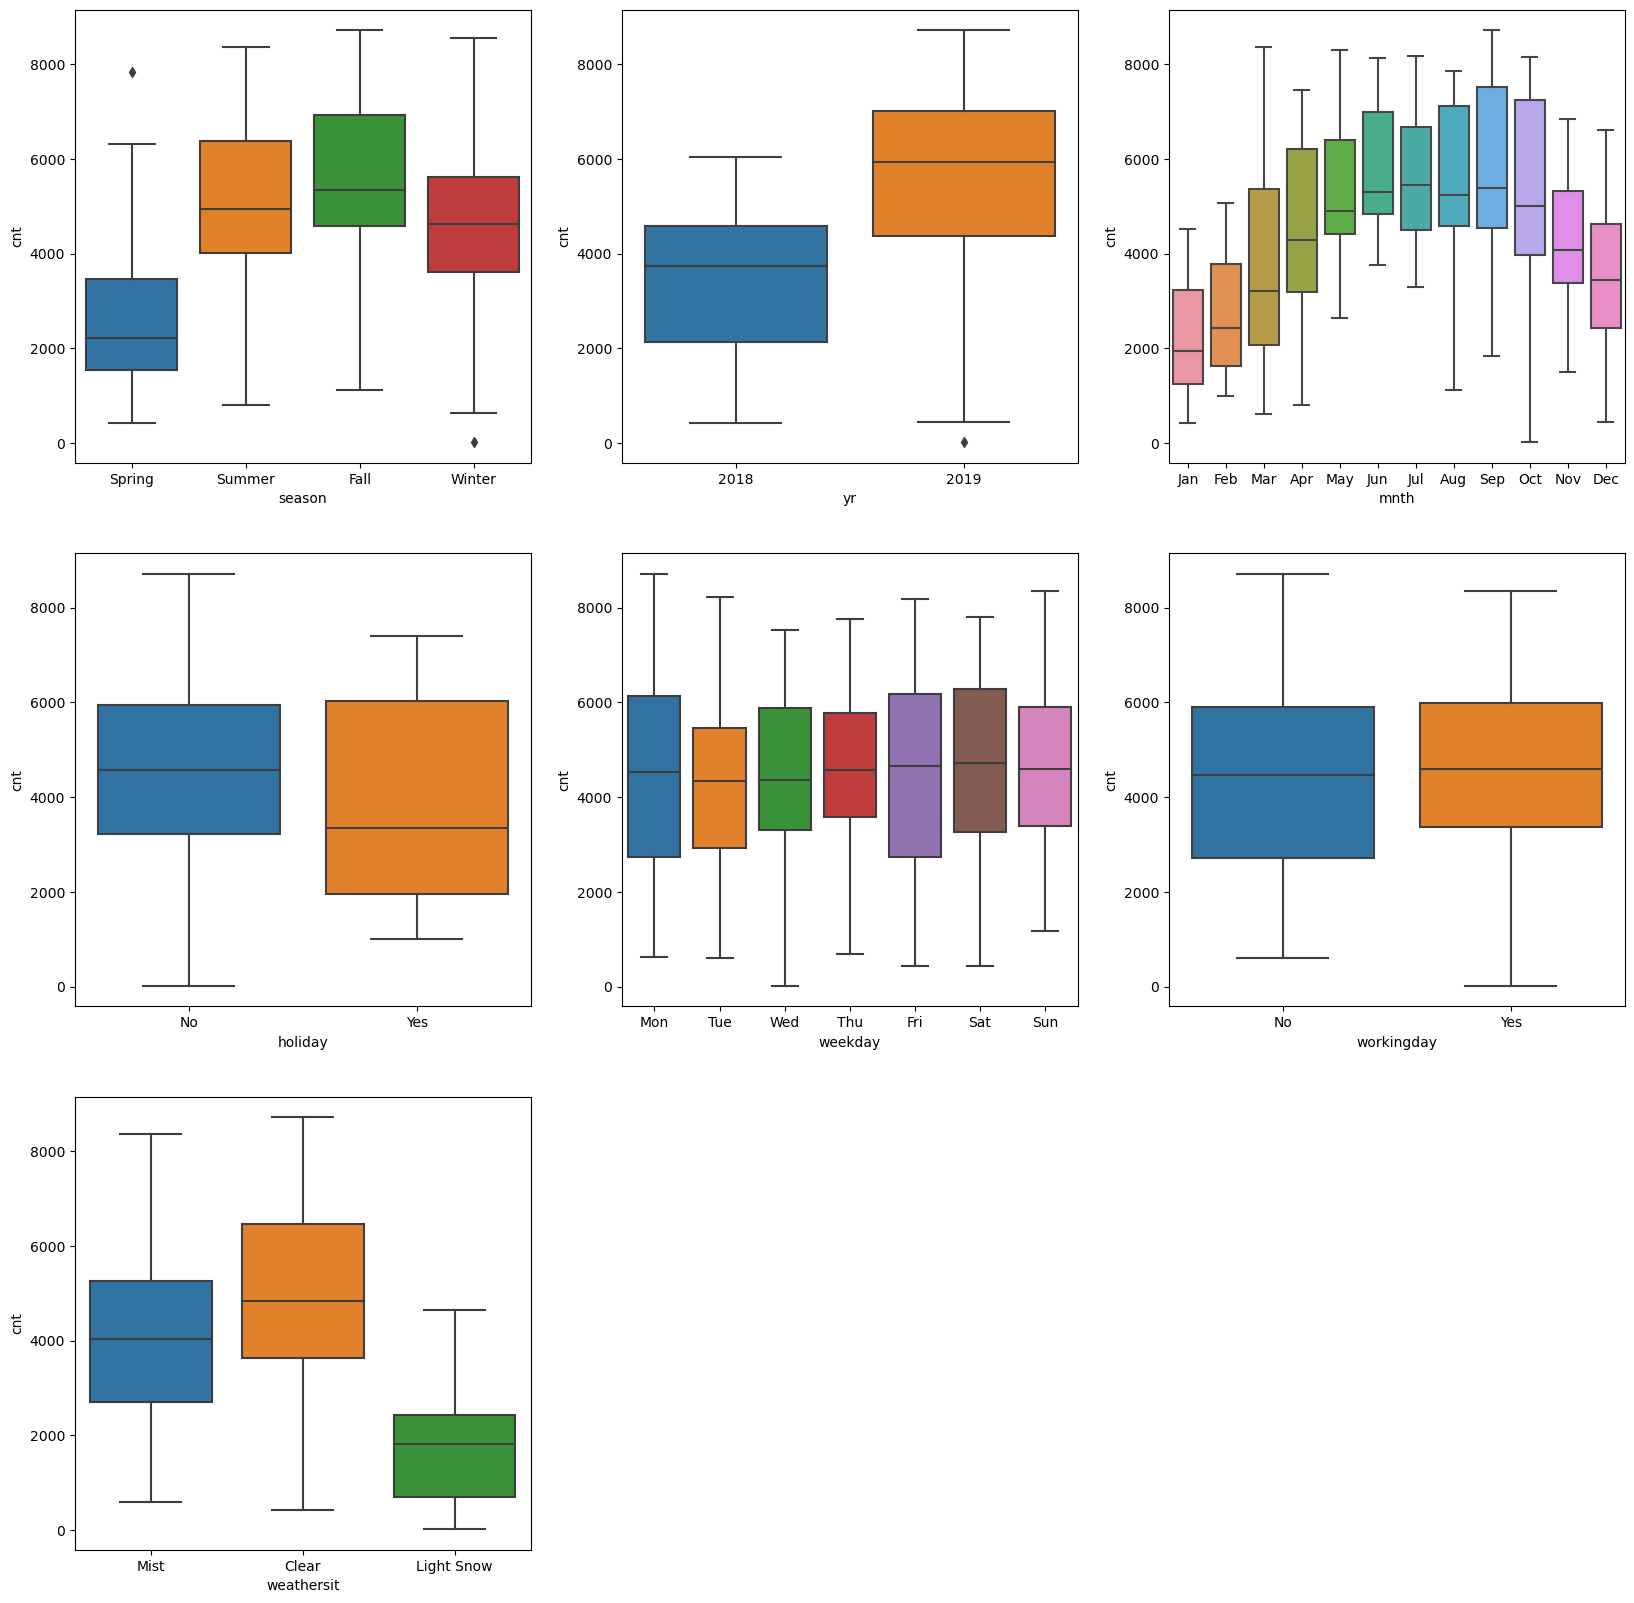

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.boxplot(x='season', y='cnt', data=bike)
plt.subplot(3,3,2)
sns.boxplot(x='yr', y='cnt', data=bike)
plt.subplot(3,3,3)
sns.boxplot(x='mnth', y='cnt', data=bike)
plt.subplot(3,3,4)
sns.boxplot(x='holiday', y='cnt', data=bike)
plt.subplot(3,3,5)
sns.boxplot(x='weekday', y='cnt', data=bike)
plt.subplot(3,3,6)
sns.boxplot(x='workingday', y='cnt', data=bike)
plt.subplot(3,3,7)
sns.boxplot(x='weathersit', y='cnt', data=bike)
plt.show()

#### Based on the graphs above, we can say:
- Demand in spring season is the visibly very low  
- Demand has increase drastically from 2018 to 2019
- Demand is highest in the month of Sep and Oct and it is lowest in the month of Dec and Jan
- Demand is slightly higher on a holiday or when its not a working day
- Not much variation in the days of the week but Mon seems to have slightly higher demand
- Deman is highest on Clear days and lowest on Snowy days

In [19]:
## yes/no variables
varlist = ['holiday','workingday']
bike[varlist] = bike[varlist].apply(lambda x:x.map({'Yes':1,'No':0}))

In [20]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,0,Mon,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,0,Tue,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Visualizing the Numerical Variable

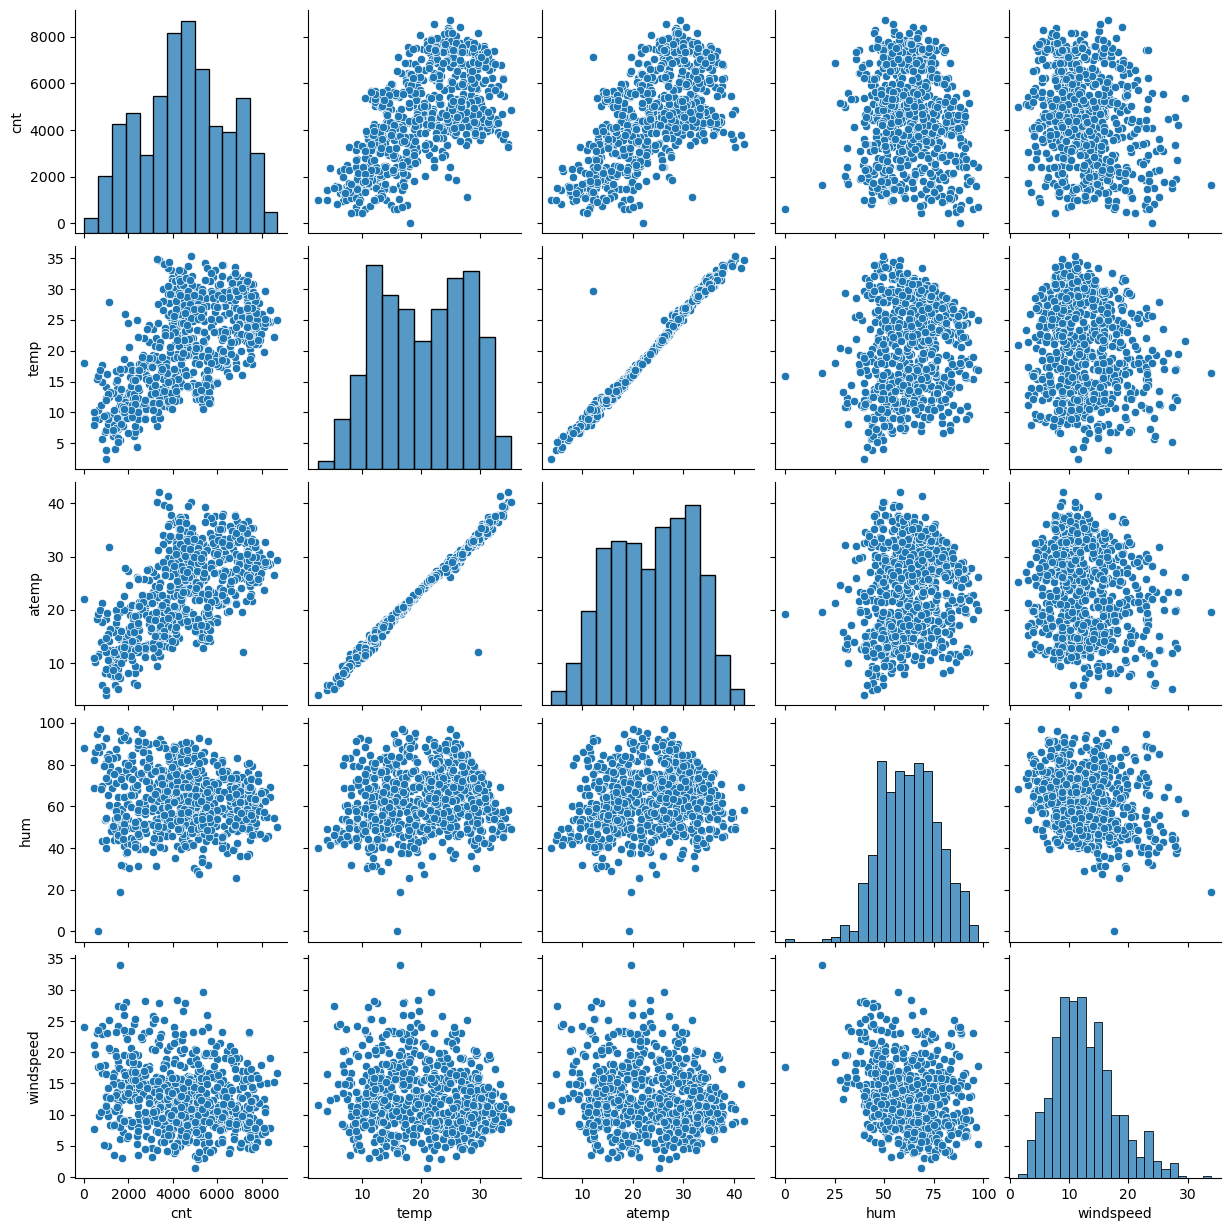

In [21]:
sns.pairplot(bike[num_cols])
plt.show()

- There seem to have a linear relation between cnt (the target variable) and temp and atemp (independent variables)

### Adding dummy variables

In [22]:
weather = pd.get_dummies(bike['weathersit'])
weather

,Clear,Light Snow,Mist
0,False,False,True
1,False,False,True
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
725,False,False,True
726,False,False,True
727,False,False,True
728,True,False,False


In [23]:
weather = weather.apply(lambda x:x.map({True: 1, False:0}))
weather

,Clear,Light Snow,Mist
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
725,0,0,1
726,0,0,1
727,0,0,1
728,1,0,0


### We dont need 3 variables here as
##### 00 - Clear
##### 01 - Mist
##### 10 - Light Snow

Therefore we can drop the redundant variable

In [24]:
weather = pd.get_dummies(bike['weathersit'],drop_first=True)
weather = weather.apply(lambda x:x.map({True: 1, False:0}))
weather.head()

,Light Snow,Mist
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [25]:
# Concat the dummy variable with the original dataframe

bike = pd.concat([bike, weather],axis=1)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,Light Snow,Mist
0,Spring,2018,Jan,0,Mon,0,Mist,14.110847,18.18125,80.5833,10.749882,985,0,1
1,Spring,2018,Jan,0,Tue,0,Mist,14.902598,17.68695,69.6087,16.652113,801,0,1
2,Spring,2018,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,0,0
3,Spring,2018,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,0,0
4,Spring,2018,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,0,0


In [26]:
# Dropping the redundant variable - weathersit

bike = bike.drop('weathersit', axis=1)

In [27]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist
0,Spring,2018,Jan,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,0,1
1,Spring,2018,Jan,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,0,1
2,Spring,2018,Jan,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,0,0
3,Spring,2018,Jan,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,0,0
4,Spring,2018,Jan,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,0,0


In [28]:
season = pd.get_dummies(bike['season'],drop_first=True)
season = season.apply(lambda x:x.map({True: 1, False:0}))
season.head()

,Spring,Summer,Winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [29]:
bike = pd.concat([bike, season],axis=1)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,Spring,Summer,Winter
0,Spring,2018,Jan,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,0,1,1,0,0
1,Spring,2018,Jan,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,0,1,1,0,0
2,Spring,2018,Jan,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,1,0,0
3,Spring,2018,Jan,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,1,0,0
4,Spring,2018,Jan,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,1,0,0


##### 000 - Fall
##### 100 - Spring
##### 010 - Summer
##### 001 - Winter

In [30]:
# Dropping the redundant variable - season

bike = bike.drop('season', axis=1)

In [31]:
bike.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,Spring,Summer,Winter
0,2018,Jan,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,0,1,1,0,0
1,2018,Jan,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,0,1,1,0,0
2,2018,Jan,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,1,0,0
3,2018,Jan,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,1,0,0
4,2018,Jan,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,1,0,0


In [32]:
month = pd.get_dummies(bike['mnth'],drop_first=True)
month = month.apply(lambda x:x.map({True: 1, False:0}))
month.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [33]:
bike = pd.concat([bike, month],axis=1)
bike.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2018,Jan,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,...,0,0,1,0,0,0,0,0,0,0
1,2018,Jan,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,...,0,0,1,0,0,0,0,0,0,0
2,2018,Jan,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,...,0,0,1,0,0,0,0,0,0,0
3,2018,Jan,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,...,0,0,1,0,0,0,0,0,0,0
4,2018,Jan,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,...,0,0,1,0,0,0,0,0,0,0


In [34]:
# Dropping the redundant variable - mnth

bike = bike.drop('mnth', axis=1)
bike.head()

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2018,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,0,...,0,0,1,0,0,0,0,0,0,0
1,2018,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,0,...,0,0,1,0,0,0,0,0,0,0
2,2018,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,0,...,0,0,1,0,0,0,0,0,0,0
3,2018,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,0,...,0,0,1,0,0,0,0,0,0,0
4,2018,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
weekday = pd.get_dummies(bike['weekday'],drop_first=True)
weekday = weekday.apply(lambda x:x.map({True: 1, False:0}))
weekday.head()

,Mon,Sat,Sun,Thu,Tue,Wed
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [36]:
bike = pd.concat([bike, weekday],axis=1)
bike.head()

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,2018,0,Mon,0,14.110847,18.18125,80.5833,10.749882,985,0,...,0,0,0,0,1,0,0,0,0,0
1,2018,0,Tue,0,14.902598,17.68695,69.6087,16.652113,801,0,...,0,0,0,0,0,0,0,0,1,0
2,2018,0,Wed,1,8.050924,9.47025,43.7273,16.636703,1349,0,...,0,0,0,0,0,0,0,0,0,1
3,2018,0,Thu,1,8.200000,10.60610,59.0435,10.739832,1562,0,...,0,0,0,0,0,0,0,1,0,0
4,2018,0,Fri,1,9.305237,11.46350,43.6957,12.522300,1600,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Dropping the redundant variable - weekday

bike = bike.drop('weekday', axis=1)
bike.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
0,2018,0,0,14.110847,18.18125,80.5833,10.749882,985,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2018,0,0,14.902598,17.68695,69.6087,16.652113,801,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2018,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2018,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2018,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
bike['yr'] = bike['yr'].apply(lambda x:0 if x=='2018' else 1)
bike.tail()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
725,1,0,1,10.420847,11.33210,65.2917,23.458911,2114,0,1,...,0,0,0,0,0,1,0,0,0,0
726,1,0,1,10.386653,12.75230,59.0000,10.416557,3095,0,1,...,0,0,0,0,0,0,1,0,0,0
727,1,0,0,10.386653,12.12000,75.2917,8.333661,1341,0,1,...,0,0,0,0,1,0,0,0,0,0
728,1,0,0,10.489153,11.58500,48.3333,23.500518,1796,0,0,...,0,0,0,0,0,0,0,0,1,0
729,1,0,1,8.849153,11.17435,57.7500,10.374682,2729,0,1,...,0,0,0,0,0,0,0,0,0,1


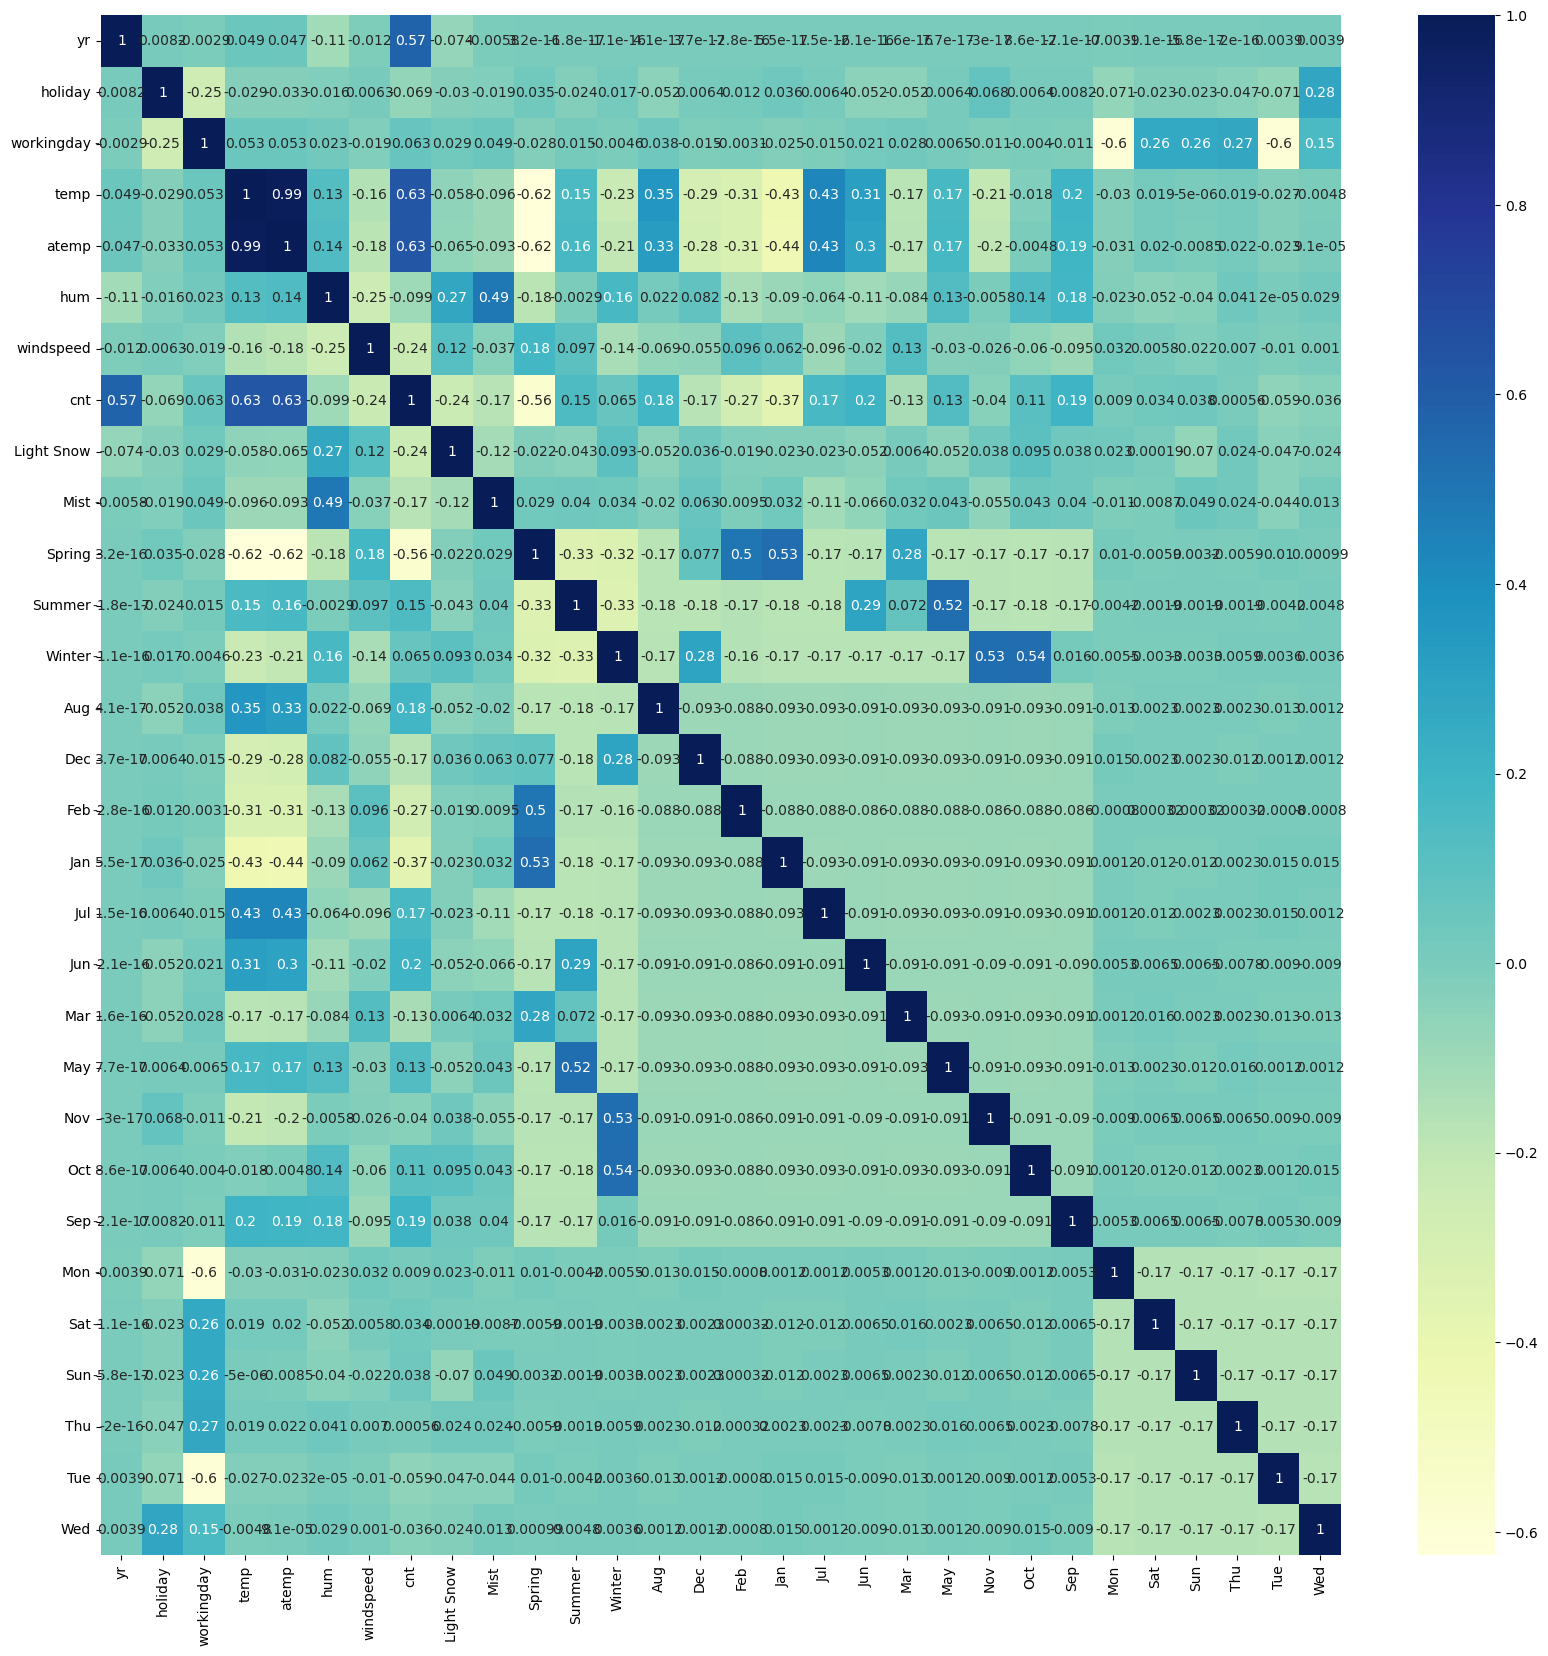

In [39]:
#Heatmap - to check correlation between the variables

plt.figure(figsize=(20,20))
sns.heatmap(bike.corr(), annot=True, annot_kws=None, cmap='YlGnBu')
plt.show()

## Step 2: Preparing the data for modelling

## Split into train and test

In [40]:
df_train, df_test = train_test_split(bike, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


## Scaling the features
#### Using Min-Max scaling

In [41]:
# 1. Instantiate the object
scaler = MinMaxScaler()

# Create a list of only Numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']

# 2. Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,1,...,0,0,0,0,1,0,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,...,0,0,0,0,0,0,0,0,1,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,1,0,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,0,0,1,0,0,0


In [42]:
y_train = df_train.pop('cnt')
X_train = df_train

In [43]:
X_train.shape

(510, 29)

## Step 3: Building our model
This time we will be using LinearRegression function from SciKitLearn for its compatibility with RFE (Recursive Feature Elimination)

In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [45]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)

In [46]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Light Snow', True, 1),
 ('Mist', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 8),
 ('Winter', True, 1),
 ('Aug', False, 3),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 7),
 ('Mar', False, 5),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', False, 9),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', False, 6),
 ('Sun', False, 2),
 ('Thu', False, 4),
 ('Tue', True, 1),
 ('Wed', False, 10)]

In [47]:
col = X_train.columns[rfe.support_]

In [48]:
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'Light Snow', 'Mist', 'Spring', 'Winter', 'Dec', 'Feb', 'Jan', 'Jul',
       'May', 'Nov', 'Sep', 'Mon', 'Tue'],
      dtype='object')

In [49]:
np.asarray(X_train).dtype

dtype('float64')

#### Building model using statsmodel, for detailed statistics

In [50]:
# Creating X_test dataframe with the RFE selected variables
X_train_rfe = X_train[col]

In [51]:
# Adding a constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

In [52]:
np.asarray(X_train_rfe).dtype

dtype('float64')

In [53]:
# Running linear model
lm = sm.OLS(y_train, X_train_rfe).fit()

In [54]:
# Print summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.0
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.04e-188
Time:                        00:37:10   Log-Likelihood:                 523.96
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     490   BIC:                            -923.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2740      0.026     10.579      0.0

In [55]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_rfe.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,temp,53.24
4,atemp,51.90
2,workingday,44.39
18,Mon,10.76
19,Tue,10.38
9,Spring,3.60
1,holiday,2.76
10,Winter,2.53
13,Jan,2.29
5,hum,1.97


- atemp is the only variable with both p-value and vif being high. Hence we can drop the variable and rebuild the model

In [56]:
X_train_new = X_train_rfe.drop(['atemp'],axis=1)

In [57]:
X_train_new.head()

,const,yr,holiday,workingday,temp,hum,windspeed,Light Snow,Mist,Spring,Winter,Dec,Feb,Jan,Jul,May,Nov,Sep,Mon,Tue
576,1.0,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1.0,1,0,0,0.442393,0.640189,0.255342,0,1,1,0,0,0,0,0,0,0,0,1,0
728,1.0,1,0,0,0.245101,0.498067,0.663106,0,0,1,0,1,0,0,0,0,0,0,0,1
482,1.0,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,0,1,0
111,1.0,0,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,0,0,0,0,0


In [58]:
lm = sm.OLS(y_train, X_train_new).fit()

In [59]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.4
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.86e-189
Time:                        00:37:10   Log-Likelihood:                 523.81
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     491   BIC:                            -929.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2750      0.026     10.649      0.0

In [60]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,44.13
17,Mon,10.70
18,Tue,10.32
3,temp,3.67
8,Spring,3.60
1,holiday,2.75
9,Winter,2.51
12,Jan,2.28
4,hum,1.96
11,Feb,1.83


In [61]:
# Dropping holiday as the p-value is >0.05

X_train_new = X_train_new.drop(['holiday'],axis=1)

In [62]:
# Building the model after dropping holiday

lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.4
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.86e-189
Time:                        00:37:11   Log-Likelihood:                 523.81
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     491   BIC:                            -929.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2831      0.041      6.966      0.0

In [63]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,32.14
2,temp,19.93
1,workingday,17.24
16,Mon,4.65
4,windspeed,4.61
17,Tue,4.50
7,Spring,4.44
8,Winter,3.24
11,Jan,2.40
6,Mist,2.31


In [64]:
# Dropping Tue as p-value for Tue is >0.05

X_train_new = X_train_new.drop(['Tue'],axis=1)

In [65]:
# Building the model after dropping Tue

lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     163.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          6.92e-190
Time:                        00:37:11   Log-Likelihood:                 522.17
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     492   BIC:                            -932.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3252      0.033      9.821      0.0

In [66]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,26.93
2,temp,18.22
1,workingday,4.68
7,Spring,4.32
4,windspeed,4.19
8,Winter,3.19
11,Jan,2.38
6,Mist,2.27
0,yr,2.08
10,Feb,1.91


In [67]:
# Dropping Feb as p-value =0.05

X_train_new = X_train_new.drop(['Feb'],axis=1)

In [68]:
# Building the model after dropping Feb

lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     172.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          3.49e-190
Time:                        00:37:11   Log-Likelihood:                 520.18
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     493   BIC:                            -934.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3152      0.033      9.606      0.0

In [69]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,hum,26.45
2,temp,17.72
1,workingday,4.67
4,windspeed,4.18
8,Winter,3.17
7,Spring,3.14
6,Mist,2.27
0,yr,2.07
15,Mon,1.83
13,Nov,1.81


- All the variables are significant now, so we will be dropping the variables with high VIF

In [70]:
# Dropping hum as VIF is >5. even though the variable is significant

X_train_new = X_train_new.drop(['hum'],axis=1)

In [71]:
# Building the model after dropping hum

lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     177.7
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          6.18e-188
Time:                        00:37:12   Log-Likelihood:                 512.08
No. Observations:                 510   AIC:                            -992.2
Df Residuals:                     494   BIC:                            -924.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2372      0.027      8.873      0.0

In [72]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,temp,7.02
1,workingday,4.57
3,windspeed,4.17
7,Winter,2.65
6,Spring,2.51
0,yr,2.07
14,Mon,1.82
12,Nov,1.79
9,Jan,1.67
5,Mist,1.57


In [73]:
# Dropping temp as the VIF > 5 even though the variable is significant

X_train_new = X_train_new.drop(['temp'],axis=1)

# Building the model after dropping temp

lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     136.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          8.54e-160
Time:                        00:37:12   Log-Likelihood:                 442.23
No. Observations:                 510   AIC:                            -854.5
Df Residuals:                     495   BIC:                            -790.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5119      0.017     29.471      0.0

In [74]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,windspeed,3.56
1,workingday,3.31
6,Winter,2.65
5,Spring,2.41
0,yr,1.88
11,Nov,1.77
8,Jan,1.64
13,Mon,1.57
4,Mist,1.56
7,Dec,1.47


- On deleting temp, vif has gone below 5 for all but 3 variables - Winter, July and May have become insignificant. So, we will be dropping them

In [75]:
# Dropping Winter

X_train_new = X_train_new.drop(['Winter'],axis=1)
lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     147.1
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          9.92e-161
Time:                        00:37:12   Log-Likelihood:                 441.85
No. Observations:                 510   AIC:                            -855.7
Df Residuals:                     496   BIC:                            -796.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5161      0.017     31.035      0.0

In [76]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,windspeed,3.52
1,workingday,3.24
5,Spring,2.18
0,yr,1.87
7,Jan,1.63
4,Mist,1.55
12,Mon,1.55
9,May,1.18
10,Nov,1.16
11,Sep,1.16


In [77]:
# Dropping Jul as the p-value for Jul is still >0.05

X_train_new = X_train_new.drop(['Jul'],axis=1)
lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     159.3
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.19e-161
Time:                        00:37:12   Log-Likelihood:                 441.40
No. Observations:                 510   AIC:                            -856.8
Df Residuals:                     497   BIC:                            -801.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5201      0.016     32.333      0.0

In [78]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,windspeed,3.50
1,workingday,3.14
5,Spring,2.13
0,yr,1.86
7,Jan,1.63
4,Mist,1.54
11,Mon,1.52
8,May,1.17
9,Nov,1.14
10,Sep,1.14


In [79]:
# Dropping May as the p-value for May is still >0.05

X_train_new = X_train_new.drop(['May'],axis=1)
lm = sm.OLS(y_train, X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     173.7
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.54e-162
Time:                        00:37:12   Log-Likelihood:                 440.83
No. Observations:                 510   AIC:                            -857.7
Df Residuals:                     498   BIC:                            -806.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5229      0.016     32.964      0.0

In [80]:
# VIF

vif = pd.DataFrame()
X_train_vif = X_train_new.drop('const',axis=1)
vif['Features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,windspeed,3.47
1,workingday,3.06
5,Spring,2.08
0,yr,1.86
7,Jan,1.63
4,Mist,1.52
10,Mon,1.52
8,Nov,1.13
6,Dec,1.12
9,Sep,1.12


- Now all the variables are significant and vif is less than 5 so we have arrived at the model.

y(cnt) = 0.5229 + 0.2456 yr + 0.0563 workingday - 0.2077 windspeed - 0.3145 Light Snow - 0.0909 Mist - 0.2209 Spring - 0.1062 Dec -0.1220 Jan - 0.0947 Nov + 0.0728 Sep + 0.0664 Mon

- The shared bike count is +vely impacted by the yr, working day, month=9 (Sep) and Day=6 (Mon). Based on these variables, the demand of the bike will increase.

- windspeed, Light Snow, Mist Spring, Dec, Jan and Nov are -vely correlated to the bike demand and thus if any of these factors increase, the demand will go down.

## Step 4: Residual Analysis

In [81]:
y_train_pred = lm.predict(X_train_new)

Text(0.5, 0, 'Errors')

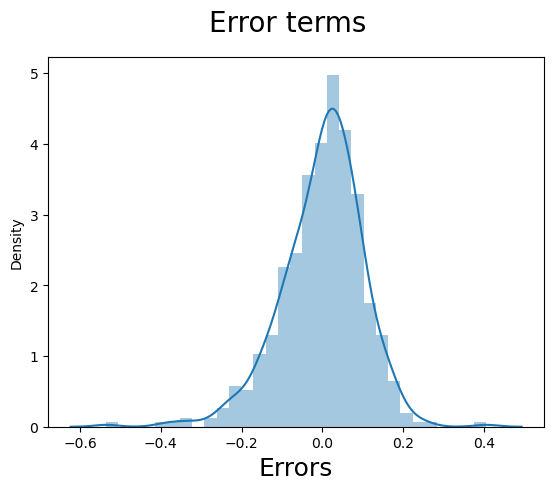

In [82]:
fig = plt.figure()

res = y_train - y_train_pred
sns.distplot(res)
fig.suptitle("Error terms", fontsize=20)
plt.xlabel('Errors',fontsize=18)

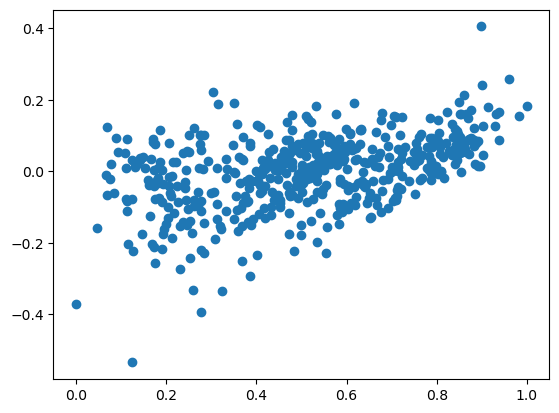

In [83]:
plt.scatter(y_train, (y_train-y_train_pred))
plt.show()

## Step 5: Predictions and Evaluation on the test data set

### Making predictions

In [84]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,20.808400,24.250312,61.934025,12.598352,4560.559091,0.027273,0.318182,...,0.086364,0.072727,0.086364,0.086364,0.118182,0.163636,0.177273,0.168182,0.145455,0.127273
std,0.500809,0.187620,0.459303,7.672796,8.281075,14.429542,4.973534,1904.968544,0.163248,0.466833,...,0.281541,0.260281,0.281541,0.281541,0.323559,0.370789,0.382770,0.374881,0.353363,0.334038
min,0.000000,0.000000,0.000000,3.957390,4.941955,25.416700,1.500244,441.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.119375,17.090025,51.354200,9.031466,3312.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,20.790424,24.700000,60.708350,12.188004,4582.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,27.299153,31.124313,72.179375,15.385361,5913.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,34.815847,41.318550,97.250000,27.999836,8395.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
# Create a list of only Numeric variables
num_vars = ['temp','atemp','hum','windspeed','cnt']

# 2. Fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Light Snow,Mist,...,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,0,0,0,0,0,0,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,1,...,0,0,1,0,0,1,0,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Dividing into X_test and y_test

In [86]:
y_test = df_test.pop('cnt')
X_test = df_test

In [87]:
# Adding a constant
X_test_new = sm.add_constant(X_test)

#X_test_new is created with the columns that were in X_train_new, which was created after dropping the redundant variables
X_test_new = X_test_new[X_train_new.columns]

In [88]:
# Making predictions
y_pred = lm.predict(X_test_new)

### Model Evaluation

Text(0, 0.5, 'y_pred')

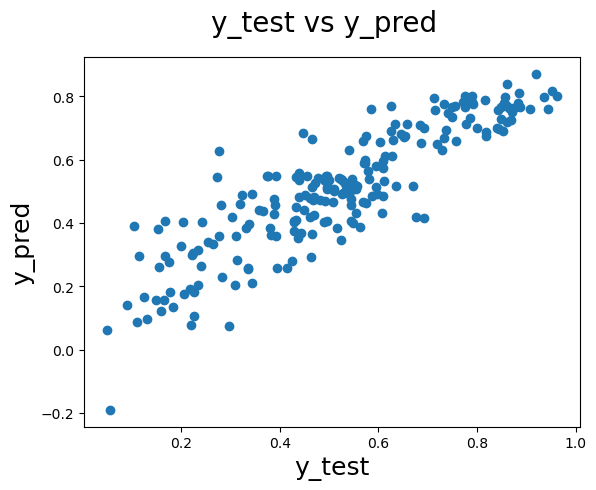

In [89]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle("y_test vs y_pred", fontsize=20)
plt.xlabel('y_test',fontsize=18)
plt.ylabel('y_pred',fontsize=18)

Text(0.5, 0, 'Errors')

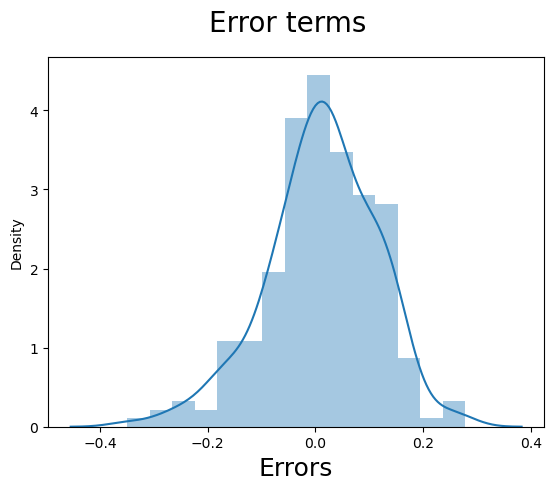

In [90]:
# Plotting the distribution of the error terms

fig = plt.figure()

res = y_test - y_pred
sns.distplot(res)
fig.suptitle("Error terms", fontsize=20)
plt.xlabel('Errors',fontsize=18)

### Calculating the r2_score for the test set

In [91]:
r2_score(y_test, y_pred)

0.7775590412058485